/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s] 


Epoch 1/10 - Train Loss: 0.5417, Train Acc: 0.8253
Epoch 1/10 - Val Loss: 0.2876, Val Acc: 0.9069
Epoch 2/10 - Train Loss: 0.2296, Train Acc: 0.9237
Epoch 2/10 - Val Loss: 0.2904, Val Acc: 0.9103
Epoch 3/10 - Train Loss: 0.1533, Train Acc: 0.9496
Epoch 3/10 - Val Loss: 0.2113, Val Acc: 0.9346
Epoch 4/10 - Train Loss: 0.1315, Train Acc: 0.9559
Epoch 4/10 - Val Loss: 0.1139, Val Acc: 0.9651
Epoch 5/10 - Train Loss: 0.1128, Train Acc: 0.9635
Epoch 5/10 - Val Loss: 0.1913, Val Acc: 0.9418
Epoch 6/10 - Train Loss: 0.0890, Train Acc: 0.9708
Epoch 6/10 - Val Loss: 0.1371, Val Acc: 0.9583
Epoch 7/10 - Train Loss: 0.0663, Train Acc: 0.9792
Epoch 7/10 - Val Loss: 0.1305, Val Acc: 0.9598
Epoch 8/10 - Train Loss: 0.0770, Train Acc: 0.9749
Epoch 8/10 - Val Loss: 0.0957, Val Acc: 0.9670
Epoch 9/10 - Train Loss: 0.0567, Train Acc: 0.9813
Epoch 9/10 - Val Loss: 0.1479, Val Acc: 0.9583
Epoch 10/10 - Train Loss: 0.0603, Train Acc: 0.9794
Epoch 10/10 - Val Loss: 0.0835, Val Acc: 0.9724
Test Accuracy: 0.9

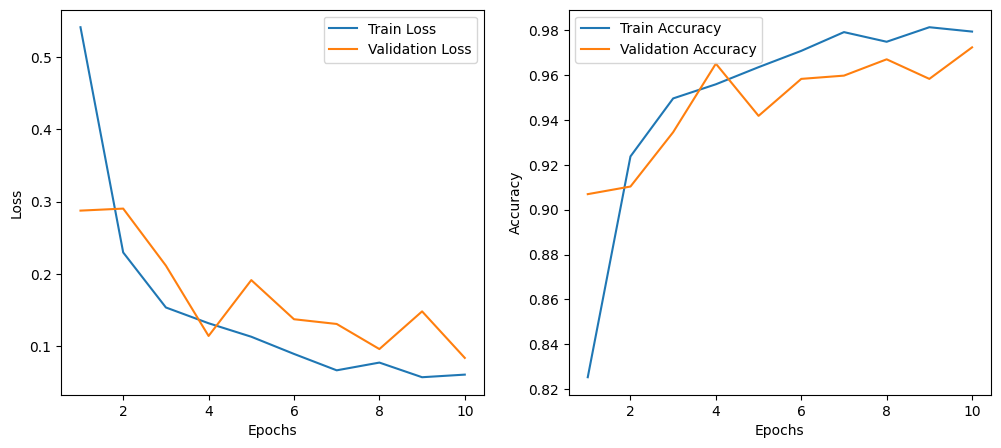

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/kaggle/input/plantdisease/PlantVillage'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet50(pretrained=True)

num_classes = len(dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate training loss and accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

tomato_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=10
)

def test_model(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

test_accuracy = test_model(tomato_model, test_loader)

def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_performance(train_losses, val_losses, train_accuracies, val_accuracies)


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


# --- Discriminator Model ---
class Discriminator(nn.Module):
    def __init__(self, img_size=224, channels=3):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.channels = channels

        # Convolution layers
        self.conv1 = nn.Conv2d(self.channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * (img_size // 16) * (img_size // 16), 1)  # Adjusting for downsampling
        
        # Sigmoid activation for the output layer to get probabilities
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.sigmoid(x)  # Output a probability for each image
        return x


# --- Generator Model ---
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_size=224, channels=3):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.img_size = img_size
        self.channels = channels

        # Fully connected layers
        self.fc1 = nn.Linear(z_dim, 512 * (img_size // 16) * (img_size // 16))
        
        # Transposed convolution layers
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = z.view(z.size(0), 512, self.img_size // 16, self.img_size // 16)
        z = F.relu(self.conv1(z))
        z = F.relu(self.conv2(z))
        z = F.relu(self.conv3(z))
        z = torch.tanh(self.conv4(z))  # Output image (scaled between -1 and 1)
        return z


# --- GAN Training Function ---
def train_gan(generator, discriminator, data_loader, num_epochs=10, z_dim=100, device='cuda'):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    real_label = 1
    fake_label = 0

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(data_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Create labels for real images (real_label)
            labels_real = torch.full((batch_size, 1), real_label, device=device)

            # --- Train the Discriminator ---
            optimizer_d.zero_grad()

            # Train with real images
            output_real = discriminator(real_images)
            errD_real = criterion(output_real, labels_real)
            errD_real.backward()

            # Generate fake images
            z = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(z)

            # Labels for fake images (fake_label)
            labels_fake = torch.full((batch_size, 1), fake_label, device=device)

            # Train with fake images
            output_fake = discriminator(fake_images.detach())
            errD_fake = criterion(output_fake, labels_fake)
            errD_fake.backward()

            optimizer_d.step()

            # --- Train the Generator ---
            optimizer_g.zero_grad()

            # We want the generator to fool the discriminator, so we use real labels for fake images
            output_fake_for_g = discriminator(fake_images)
            errG = criterion(output_fake_for_g, labels_real)
            errG.backward()

            optimizer_g.step()

            # Print statistics
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], "
                      f"Loss D: {errD_real.item() + errD_fake.item():.4f}, Loss G: {errG.item():.4f}")

    return generator, discriminator


# --- Data Augmentation Function ---
def augment_data(real_data, synthetic_data):
    """
    Combines real data and synthetic data into one augmented dataset
    """
    augmented_data = torch.cat([real_data, synthetic_data], dim=0)
    return augmented_data


# --- Testing Function ---
def test_model(generator, discriminator, test_loader, z_dim=100, device='cuda'):
    generator.eval()
    discriminator.eval()

    all_real_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for real_images, _ in test_loader:
            real_images = real_images.to(device)

            # Get discriminator predictions for real images
            real_labels = torch.full((real_images.size(0), 1), 1, device=device)
            outputs = discriminator(real_images)

            all_real_labels.extend(real_labels.cpu().numpy())
            all_pred_labels.extend(outputs.cpu().numpy())

            # Generate fake images and get discriminator predictions
            z = torch.randn(real_images.size(0), z_dim, device=device)
            fake_images = generator(z)

            fake_labels = torch.full((real_images.size(0), 1), 0, device=device)
            fake_outputs = discriminator(fake_images)

            all_real_labels.extend(fake_labels.cpu().numpy())
            all_pred_labels.extend(fake_outputs.cpu().numpy())

    # Calculate precision, recall, and F1-score here based on predictions
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(all_real_labels, np.array(all_pred_labels) > 0.5)
    recall = recall_score(all_real_labels, np.array(all_pred_labels) > 0.5)
    f1 = f1_score(all_real_labels, np.array(all_pred_labels) > 0.5)

    return precision, recall, f1


# --- Helper Function to Plot Performance ---
def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


# --- Main Pipeline Execution ---
# Assuming you have already set up your DataLoader for train_loader, val_loader, and test_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
z_dim = 100  # Latent space dimension for the generator
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Train the GAN
generator, discriminator = train_gan(generator, discriminator, train_loader, num_epochs=10, z_dim=z_dim, device=device)

# Test the model performance
precision, recall, f1 = test_model(generator, discriminator, test_loader, z_dim=z_dim, device=device)

# Print performance metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


RuntimeError: Found dtype Long but expected Float

In [24]:
z_dim = 100  # Latent vector dimension for the generator
img_channels = 3  # For RGB images

# Create the models
generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Binary Cross-Entropy loss
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002  # Learning rate
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [25]:
def train_gan(generator, discriminator, data_loader, num_epochs=10, z_dim=100, device='cuda'):
    real_label = 1
    fake_label = 0
    
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(data_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train the Discriminator with real images
            optimizer_disc.zero_grad()
            labels_real = torch.full((batch_size,), real_label, device=device)
            output_real = discriminator(real_images).view(-1)
            errD_real = criterion(output_real, labels_real)
            errD_real.backward()

            # Train the Discriminator with fake images
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_images = generator(z)
            labels_fake = torch.full((batch_size,), fake_label, device=device)
            output_fake = discriminator(fake_images.detach()).view(-1)
            errD_fake = criterion(output_fake, labels_fake)
            errD_fake.backward()
            optimizer_disc.step()

            # Train the Generator (we want the Discriminator to think fake images are real)
            optimizer_gen.zero_grad()
            output = discriminator(fake_images).view(-1)
            errG = criterion(output, labels_real)
            errG.backward()
            optimizer_gen.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {errD_real.item() + errD_fake.item():.4f}, Loss G: {errG.item():.4f}")
    
    return generator, discriminator


In [26]:
def generate_synthetic_images(generator, num_images=1000, z_dim=100, device='cuda'):
    z = torch.randn(num_images, z_dim, 1, 1, device=device)  # Latent vector (random noise)
    synthetic_images = generator(z)
    return synthetic_images


In [27]:
from torch.utils.data import TensorDataset

def augment_data(train_loader, synthetic_images):
    # Convert synthetic images to the same format as real images
    synthetic_images = synthetic_images.detach().cpu().numpy()
    synthetic_images = torch.tensor(synthetic_images, dtype=torch.float32)

    # Get the real images from the train_loader
    real_images = []
    real_labels = []
    for images, labels in train_loader:
        real_images.append(images)
        real_labels.append(labels)
    
    real_images = torch.cat(real_images)
    real_labels = torch.cat(real_labels)

    # Combine real and synthetic data
    augmented_images = torch.cat((real_images, synthetic_images), dim=0)
    augmented_labels = torch.cat((real_labels, real_labels), dim=0)  # Same labels for synthetic data

    # Create a new DataLoader with the augmented dataset
    augmented_dataset = TensorDataset(augmented_images, augmented_labels)
    augmented_loader = DataLoader(augmented_dataset, batch_size=train_loader.batch_size, shuffle=True)

    return augmented_loader


In [28]:
def run_pipeline_with_gan(data_loader, num_epochs=10):
    # Train the GAN first
    generator, discriminator = train_gan(generator, discriminator, data_loader, num_epochs=num_epochs)
    
    # Generate synthetic images using the trained generator
    synthetic_images = generate_synthetic_images(generator, num_images=1000, z_dim=100, device=device)
    
    # Augment the training data with synthetic images
    augmented_train_loader = augment_data(data_loader, synthetic_images)
    
    # Train your classifier (ResNet or any other model) on the augmented dataset
    model = models.resnet50(pretrained=True).to(device)
    model.fc = torch.nn.Linear(model.fc.in_features, len(data_loader.dataset.dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Now train your model with augmented data
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in augmented_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(augmented_train_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}")

    return model, train_losses


In [29]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

In [ ]:
generator, discriminator = train_gan(generator, discriminator, train_loader, num_epochs=10, z_dim=100, device=device)


In [20]:
from torchvision import models
import torch.nn as nn

def initialize_resnet50(num_classes):
    model = models.resnet50(pretrained=True)  # Load pre-trained ResNet50 model
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify final layer for custom classification
    return model.to(device)

# Get the number of unique classes in the dataset
num_classes = len(set(tomato_labels))  # Change this according to your dataset

# Initialize the model
resnet50_model = initialize_resnet50(num_classes)


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)


In [26]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [27]:
def test_model(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy


In [28]:
print("Training Tomato dataset...")
tomato_model, tomato_train_losses, tomato_val_losses, tomato_train_accuracies, tomato_val_accuracies = train_model(
    resnet50_model, criterion, optimizer, train_loader_tomato, val_loader_tomato, num_epochs=10
)

print("Testing Tomato dataset...")
tomato_test_accuracy = test_model(tomato_model, test_loader_tomato)

print("Training Pepper dataset...")
pepper_model, pepper_train_losses, pepper_val_losses, pepper_train_accuracies, pepper_val_accuracies = train_model(
    resnet50_model, criterion, optimizer, train_loader_pepper, val_loader_pepper, num_epochs=10
)
pepper_test_accuracy = test_model(pepper_model, test_loader_pepper)

print("Training Potato dataset...")
potato_model, potato_train_losses, potato_val_losses, potato_train_accuracies, potato_val_accuracies = train_model(
    resnet50_model, criterion, optimizer, train_loader_potato, val_loader_potato, num_epochs=10
)
potato_test_accuracy = test_model(potato_model, test_loader_potato)


Training Tomato dataset...


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 256, 256, 3] to have 3 channels, but got 256 channels instead

In [25]:
def plot_history(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_history(tomato_train_losses, tomato_val_losses, tomato_train_accuracies, tomato_val_accuracies)
plot_history(pepper_train_losses, pepper_val_losses, pepper_train_accuracies, pepper_val_accuracies)
plot_history(potato_train_losses, potato_val_losses, potato_train_accuracies, potato_val_accuracies)


NameError: name 'tomato_train_losses' is not defined

In [38]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/kaggle/input/plantdisease/PlantVillage'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
import torch
from torchvision import datasets
from collections import defaultdict

data_dir = '/kaggle/input/plantdisease/PlantVillage'

dataset = datasets.ImageFolder(root=data_dir)

tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

potato_classes = [
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

pepper_classes = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy'
]

tomato_dataset = defaultdict(list)
potato_dataset = defaultdict(list)
pepper_dataset = defaultdict(list)

for img_path, label in dataset.samples:
    class_name = dataset.classes[label]
    
    if class_name in tomato_classes:
        tomato_dataset[class_name].append(img_path)
    elif class_name in potato_classes:
        potato_dataset[class_name].append(img_path)
    elif class_name in pepper_classes:
        pepper_dataset[class_name].append(img_path)

def print_dataset_summary(dataset_name, dataset):
    total_images = sum(len(img_paths) for img_paths in dataset.values())
    print(f"\nTotal number of {dataset_name} images: {total_images} images")
    for class_name, img_paths in dataset.items():
        print(f"{class_name}: {len(img_paths)} images")

print("\nTotal Tomato Dataset:")
total_tomato = sum(len(img_paths) for img_paths in tomato_dataset.values())
print(f"Total number of Tomato images: {total_tomato} images")
for class_name, img_paths in tomato_dataset.items():
    print(f"{class_name}: {len(img_paths)} images")

print("\nTotal Potato Dataset:")
total_potato = sum(len(img_paths) for img_paths in potato_dataset.values())
print(f"Total number of Potato images: {total_potato} images")
for class_name, img_paths in potato_dataset.items():
    print(f"{class_name}: {len(img_paths)} images")

print("\nTotal Pepper Dataset:")
total_pepper = sum(len(img_paths) for img_paths in pepper_dataset.values())
print(f"Total number of Pepper images: {total_pepper} images")
for class_name, img_paths in pepper_dataset.items():
    print(f"{class_name}: {len(img_paths)} images")



Total Tomato Dataset:
Total number of Tomato images: 16011 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato_healthy: 1591 images

Total Potato Dataset:
Total number of Potato images: 2152 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images

Total Pepper Dataset:
Total number of Pepper images: 2475 images
Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 3*224*224)

    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x.view(-1, 3, 224, 224)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3*224*224, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))  # Using ReLU instead of LeakyReLU
        x = torch.relu(self.fc2(x))  # Using ReLU instead of LeakyReLU
        x = torch.relu(self.fc3(x))  # Using ReLU instead of LeakyReLU
        return torch.sigmoid(self.fc4(x))

generator = Generator()
discriminator = Discriminator()

adversarial_loss = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Create the data loader for Tomato-related classes
tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tomato_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
tomato_indices = [i for i, (path, label) in enumerate(tomato_dataset.samples) if tomato_dataset.classes[label] in tomato_classes]
tomato_dataset = torch.utils.data.Subset(tomato_dataset, tomato_indices)


batch_size = 64
dataloader = DataLoader(tomato_dataset, batch_size=batch_size, shuffle=True)

# Training the GAN
num_epochs = 10
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Train the Discriminator
        real_imgs = imgs
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        optimizer_d.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)

        z = torch.randn(batch_size, 100)
        fake_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        optimizer_g.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save generated images
    if (epoch + 1) % 5 == 0:
        save_image(fake_imgs.data[:25], f'gan_generated_images_epoch_{epoch + 1}.png', nrow=5, normalize=True)



hudai


ValueError: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([11, 1])) is deprecated. Please ensure they have the same size.

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

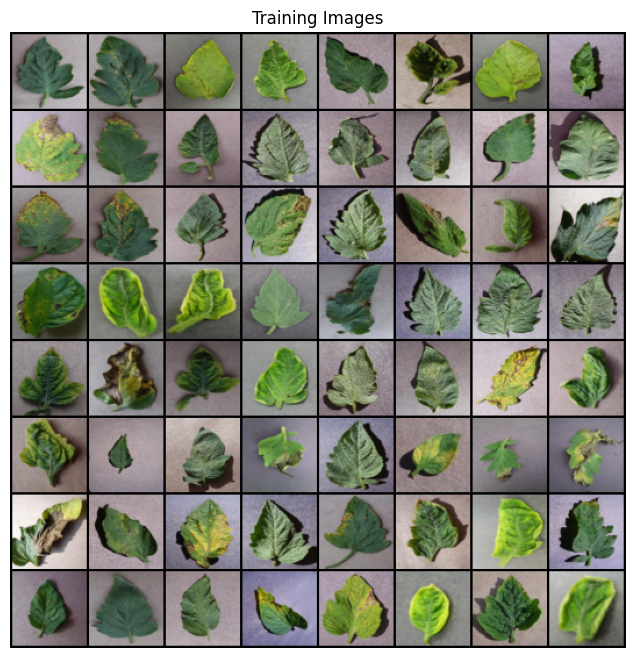

Filtered Classes:
Tomato_Bacterial_spot: 5
Tomato_Early_blight: 6
Tomato_Late_blight: 7
Tomato_Leaf_Mold: 8
Tomato_Septoria_leaf_spot: 9
Tomato_Spider_mites_Two_spotted_spider_mite: 10
Tomato__Target_Spot: 11
Tomato__Tomato_YellowLeaf__Curl_Virus: 12
Tomato__Tomato_mosaic_virus: 13
Tomato_healthy: 14


In [4]:
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

dataroot = '/kaggle/input/plantdisease/PlantVillage'

image_size = 64
batch_size = 64
workers = 2
ngpu = 1

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root=dataroot, transform=transform)

class_to_idx = {cls: idx for cls, idx in dataset.class_to_idx.items() if cls in tomato_classes}
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping for visualization
filtered_indices = [i for i, (path, label) in enumerate(dataset.samples) if label in class_to_idx.values()]

filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
filtered_dataset.classes = list(class_to_idx.keys())
filtered_dataset.class_to_idx = class_to_idx

dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

print("Filtered Classes:")
for cls, idx in filtered_dataset.class_to_idx.items():
    print(f"{cls}: {idx}")


In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [7]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/251]	Loss_D: 1.6473	Loss_G: 7.1168	D(x): 0.7121	D(G(z)): 0.6499 / 0.0014
[0/5][50/251]	Loss_D: 0.1806	Loss_G: 15.0882	D(x): 0.9140	D(G(z)): 0.0000 / 0.0000
[0/5][100/251]	Loss_D: 0.4105	Loss_G: 4.6918	D(x): 0.8661	D(G(z)): 0.1934 / 0.0150
[0/5][150/251]	Loss_D: 0.2446	Loss_G: 3.2493	D(x): 0.8816	D(G(z)): 0.0890 / 0.0680
[0/5][200/251]	Loss_D: 0.1616	Loss_G: 4.7173	D(x): 0.9356	D(G(z)): 0.0798 / 0.0132
[0/5][250/251]	Loss_D: 0.1891	Loss_G: 3.6085	D(x): 0.8992	D(G(z)): 0.0705 / 0.0333
[1/5][0/251]	Loss_D: 0.2132	Loss_G: 4.4419	D(x): 0.9328	D(G(z)): 0.1145 / 0.0207
[1/5][50/251]	Loss_D: 0.5743	Loss_G: 6.3493	D(x): 0.8795	D(G(z)): 0.3085 / 0.0060
[1/5][100/251]	Loss_D: 0.2324	Loss_G: 3.8172	D(x): 0.9166	D(G(z)): 0.1226 / 0.0381
[1/5][150/251]	Loss_D: 0.5496	Loss_G: 5.1913	D(x): 0.8776	D(G(z)): 0.3021 / 0.0094
[1/5][200/251]	Loss_D: 0.8068	Loss_G: 6.1605	D(x): 0.9706	D(G(z)): 0.4420 / 0.0039
[1/5][250/251]	Loss_D: 0.2981	Loss_G: 4.4859	D(x): 0.8199	D(G(z)):

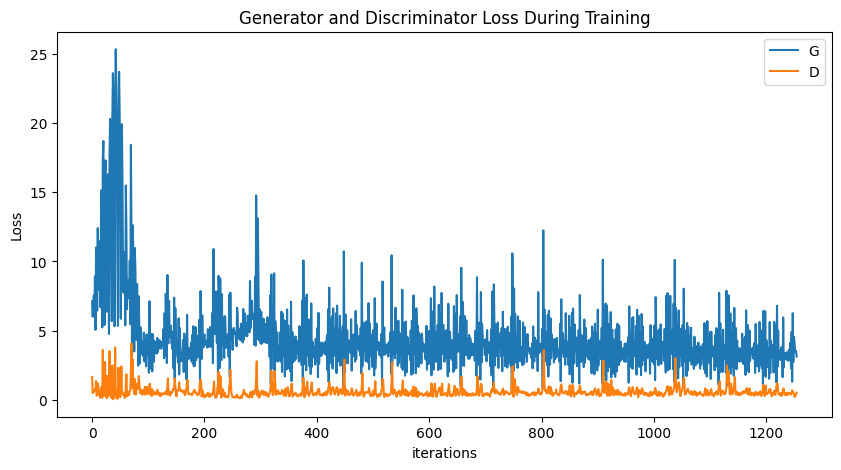

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

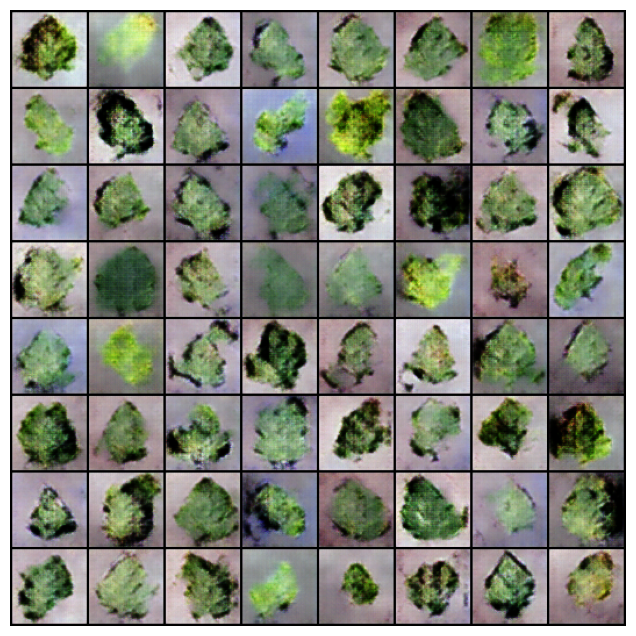

In [13]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

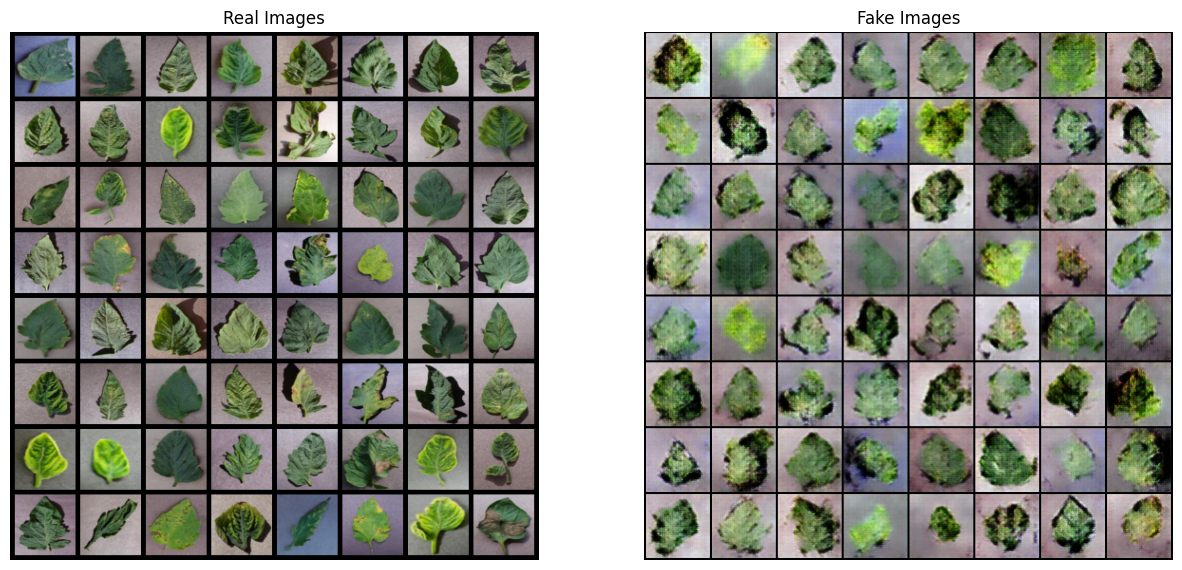

In [14]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
torch.save(generator.state_dict(), 'generator_weights.pth')


In [19]:
generator.load_state_dict(torch.load('generator_weights.pth', weights_only=True))

generator.eval()


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)